# Data Cleaning

In [7]:
import pandas as pd
import numpy as np
from transformers import BertModel, BertTokenizer
from datasets import tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader

In [9]:
path = 'reddit_mental_health.csv'

# data overview
df = pd.read_csv(path)
df

Unnamed: 0                                               text  \
0              0  Welcome to /r/depression's check-in post - a p...   
1              1  We understand that most people who reply immed...   
2              2  Anyone else just miss physical touch? I crave ...   
3              3  I’m just so ashamed. Everyone and everything f...   
4              4  I really need a friend. I don't even have a si...   
...          ...                                                ...   
5952        1183  I’ve (24M) dealt with depression/anxiety for y...   
5953        1184   "I don't feel very good, it's like I don't be...   
5954        1185  I can't sleep most of the nights, meds didn't ...   
5955        1186  Hi, all. I have to give a presentation at work...   
5956        1187  It's not about being scared I didn't lock the ...   

                                                  title  target  
0     Regular check-in post, with information about ...       1  
1     Our most-broken and least-understood rules is ...       1  
2     I haven’t been touched, or even hugged, in so ...       1  
3                       Being Depressed is Embarrassing       1  
4     I'm desperate for a friend and to feel loved b...       1  
...                                                 ...     ...  
5952                          Nobody takes me seriously       4  
5953                                        selfishness       4  
5954                  Is there any way to sleep better?       4  
5955                              Public speaking tips?       4  
5956                    I have really bad door anxiety!       4  

[5957 rows x 4 columns]

In [10]:
# drop the rows with missing values
df1 = df.dropna()
df1

Unnamed: 0                                               text  \
0              0  Welcome to /r/depression's check-in post - a p...   
1              1  We understand that most people who reply immed...   
2              2  Anyone else just miss physical touch? I crave ...   
3              3  I’m just so ashamed. Everyone and everything f...   
4              4  I really need a friend. I don't even have a si...   
...          ...                                                ...   
5952        1183  I’ve (24M) dealt with depression/anxiety for y...   
5953        1184   "I don't feel very good, it's like I don't be...   
5954        1185  I can't sleep most of the nights, meds didn't ...   
5955        1186  Hi, all. I have to give a presentation at work...   
5956        1187  It's not about being scared I didn't lock the ...   

                                                  title  target  
0     Regular check-in post, with information about ...       1  
1     Our most-broken and least-understood rules is ...       1  
2     I haven’t been touched, or even hugged, in so ...       1  
3                       Being Depressed is Embarrassing       1  
4     I'm desperate for a friend and to feel loved b...       1  
...                                                 ...     ...  
5952                          Nobody takes me seriously       4  
5953                                        selfishness       4  
5954                  Is there any way to sleep better?       4  
5955                              Public speaking tips?       4  
5956                    I have really bad door anxiety!       4  

[5607 rows x 4 columns]

In [11]:
# drop the 'row number' column since it's just an identifier
df2 = df1.drop(df1.columns[0], axis=1)
df2

# also note that we have a pretty balanced dataset!

text  \
0     Welcome to /r/depression's check-in post - a p...   
1     We understand that most people who reply immed...   
2     Anyone else just miss physical touch? I crave ...   
3     I’m just so ashamed. Everyone and everything f...   
4     I really need a friend. I don't even have a si...   
...                                                 ...   
5952  I’ve (24M) dealt with depression/anxiety for y...   
5953   "I don't feel very good, it's like I don't be...   
5954  I can't sleep most of the nights, meds didn't ...   
5955  Hi, all. I have to give a presentation at work...   
5956  It's not about being scared I didn't lock the ...   

                                                  title  target  
0     Regular check-in post, with information about ...       1  
1     Our most-broken and least-understood rules is ...       1  
2     I haven’t been touched, or even hugged, in so ...       1  
3                       Being Depressed is Embarrassing       1  
4     I'm desperate for a friend and to feel loved b...       1  
...                                                 ...     ...  
5952                          Nobody takes me seriously       4  
5953                                        selfishness       4  
5954                  Is there any way to sleep better?       4  
5955                              Public speaking tips?       4  
5956                    I have really bad door anxiety!       4  

[5607 rows x 3 columns]

In [12]:
# check if the datatypes are correct
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5607 entries, 0 to 5956
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5607 non-null   object
 1   title   5607 non-null   object
 2   target  5607 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 175.2+ KB


In [13]:
# change "title" and "text" columns to string datatype
df3 = df2.copy()
df3["title"] = df2["title"].astype("string")
df3["text"] = df2["text"].astype("string")

df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5607 entries, 0 to 5956
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5607 non-null   string
 1   title   5607 non-null   string
 2   target  5607 non-null   int64 
dtypes: int64(1), string(2)
memory usage: 175.2 KB


# LDA and Topic Modeling - LILIANA

In [14]:
import nltk
import gensim
from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

nltk.download('stopwords')
nltk.download('punkt')

def preprocess(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()  # Lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenization
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]  # Remove stopwords & non-alpha words
    return tokens

# Apply preprocessing
df3['processed_text'] = df3['text'].apply(preprocess)

# Create dictionary and corpus
dictionary = corpora.Dictionary(df3['processed_text'])
corpus = [dictionary.doc2bow(text) for text in df3['processed_text']]

# Train LDA model
lda_model = gensim.models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)

# Display topics
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lilia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lilia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(0, '0.020*"im" + 0.019*"like" + 0.016*"feel" + 0.012*"get" + 0.009*"know" + 0.008*"dont" + 0.008*"even" + 0.008*"time" + 0.007*"really" + 0.007*"ive"')
(1, '0.021*"like" + 0.019*"people" + 0.015*"feel" + 0.014*"im" + 0.010*"know" + 0.009*"dont" + 0.008*"even" + 0.008*"think" + 0.007*"really" + 0.007*"one"')
(2, '0.014*"stress" + 0.007*"anxiety" + 0.006*"time" + 0.004*"help" + 0.004*"take" + 0.004*"breathing" + 0.004*"life" + 0.004*"like" + 0.004*"experience" + 0.003*"feeling"')
(3, '0.011*"like" + 0.008*"would" + 0.008*"want" + 0.007*"said" + 0.007*"even" + 0.007*"time" + 0.007*"know" + 0.007*"never" + 0.006*"life" + 0.006*"im"')
(4, '0.018*"anxiety" + 0.008*"take" + 0.007*"bipolar" + 0.006*"anyone" + 0.006*"meds" + 0.006*"get" + 0.005*"started" + 0.005*"taking" + 0.005*"back" + 0.005*"symptoms"')


In [15]:
# Assign dominant topic to each document
def get_dominant_topic(lda_model, corpus):
    topics = []
    for row in lda_model[corpus]:  # Get topic distribution for each document
        dominant_topic = sorted(row, key=lambda x: x[1], reverse=True)[0][0]  # Get topic with highest probability
        topics.append(dominant_topic)
    return topics

# Get dominant topics
df3['dominant_topic'] = get_dominant_topic(lda_model, corpus)

# Define topic labels
topic_labels = {
    0: "Personal Feelings & Emotional States",
    1: "Social Interactions & Relationships",
    2: "Stress & Anxiety Management",
    3: "Life Decisions & Uncertainty",
    4: "Mental Health & Medication"
}

# Assign topic names
df3['topic_name'] = df3['dominant_topic'].map(topic_labels)

df3

text  \
0     Welcome to /r/depression's check-in post - a p...   
1     We understand that most people who reply immed...   
2     Anyone else just miss physical touch? I crave ...   
3     I’m just so ashamed. Everyone and everything f...   
4     I really need a friend. I don't even have a si...   
...                                                 ...   
5952  I’ve (24M) dealt with depression/anxiety for y...   
5953   "I don't feel very good, it's like I don't be...   
5954  I can't sleep most of the nights, meds didn't ...   
5955  Hi, all. I have to give a presentation at work...   
5956  It's not about being scared I didn't lock the ...   

                                                  title  target  \
0     Regular check-in post, with information about ...       1   
1     Our most-broken and least-understood rules is ...       1   
2     I haven’t been touched, or even hugged, in so ...       1   
3                       Being Depressed is Embarrassing       1   
4     I'm desperate for a friend and to feel loved b...       1   
...                                                 ...     ...   
5952                          Nobody takes me seriously       4   
5953                                        selfishness       4   
5954                  Is there any way to sleep better?       4   
5955                              Public speaking tips?       4   
5956                    I have really bad door anxiety!       4   

                                         processed_text  dominant_topic  \
0     [welcome, rdepressions, checkin, post, place, ...               1   
1     [understand, people, reply, immediately, op, i...               1   
2          [anyone, else, miss, physical, touch, crave]               1   
3     [ashamed, everyone, everything, feels, far, aw...               0   
4     [really, need, friend, dont, even, single, bes...               1   
...                                                 ...             ...   
5952  [dealt, depressionanxiety, years, used, great,...               0   
5953  [dont, feel, good, like, dont, belong, world, ...               3   
5954           [cant, sleep, nights, meds, didnt, help]               0   
5955  [hi, give, presentation, work, next, week, min...               0   
5956  [scared, didnt, lock, door, something, im, rea...               0   

                                topic_name  
0      Social Interactions & Relationships  
1      Social Interactions & Relationships  
2      Social Interactions & Relationships  
3     Personal Feelings & Emotional States  
4      Social Interactions & Relationships  
...                                    ...  
5952  Personal Feelings & Emotional States  
5953          Life Decisions & Uncertainty  
5954  Personal Feelings & Emotional States  
5955  Personal Feelings & Emotional States  
5956  Personal Feelings & Emotional States  

[5607 rows x 6 columns]

In [16]:
# combine "title" and "text" into one column called "combined_text"
df4 = df3.copy()
df4["combined_text"] = df3["title"] + " " + df3["text"]
df4.drop(columns=["title", "text"], inplace=True)
df4

target                                     processed_text  \
0          1  [welcome, rdepressions, checkin, post, place, ...   
1          1  [understand, people, reply, immediately, op, i...   
2          1       [anyone, else, miss, physical, touch, crave]   
3          1  [ashamed, everyone, everything, feels, far, aw...   
4          1  [really, need, friend, dont, even, single, bes...   
...      ...                                                ...   
5952       4  [dealt, depressionanxiety, years, used, great,...   
5953       4  [dont, feel, good, like, dont, belong, world, ...   
5954       4           [cant, sleep, nights, meds, didnt, help]   
5955       4  [hi, give, presentation, work, next, week, min...   
5956       4  [scared, didnt, lock, door, something, im, rea...   

      dominant_topic                            topic_name  \
0                  1   Social Interactions & Relationships   
1                  1   Social Interactions & Relationships   
2                  1   Social Interactions & Relationships   
3                  0  Personal Feelings & Emotional States   
4                  1   Social Interactions & Relationships   
...              ...                                   ...   
5952               0  Personal Feelings & Emotional States   
5953               3          Life Decisions & Uncertainty   
5954               0  Personal Feelings & Emotional States   
5955               0  Personal Feelings & Emotional States   
5956               0  Personal Feelings & Emotional States   

                                          combined_text  
0     Regular check-in post, with information about ...  
1     Our most-broken and least-understood rules is ...  
2     I haven’t been touched, or even hugged, in so ...  
3     Being Depressed is Embarrassing I’m just so as...  
4     I'm desperate for a friend and to feel loved b...  
...                                                 ...  
5952  Nobody takes me seriously I’ve (24M) dealt wit...  
5953  selfishness  "I don't feel very good, it's lik...  
5954  Is there any way to sleep better? I can't slee...  
5955  Public speaking tips? Hi, all. I have to give ...  
5956  I have really bad door anxiety! It's not about...  

[5607 rows x 5 columns]

<Figure size 1200x600 with 0 Axes>

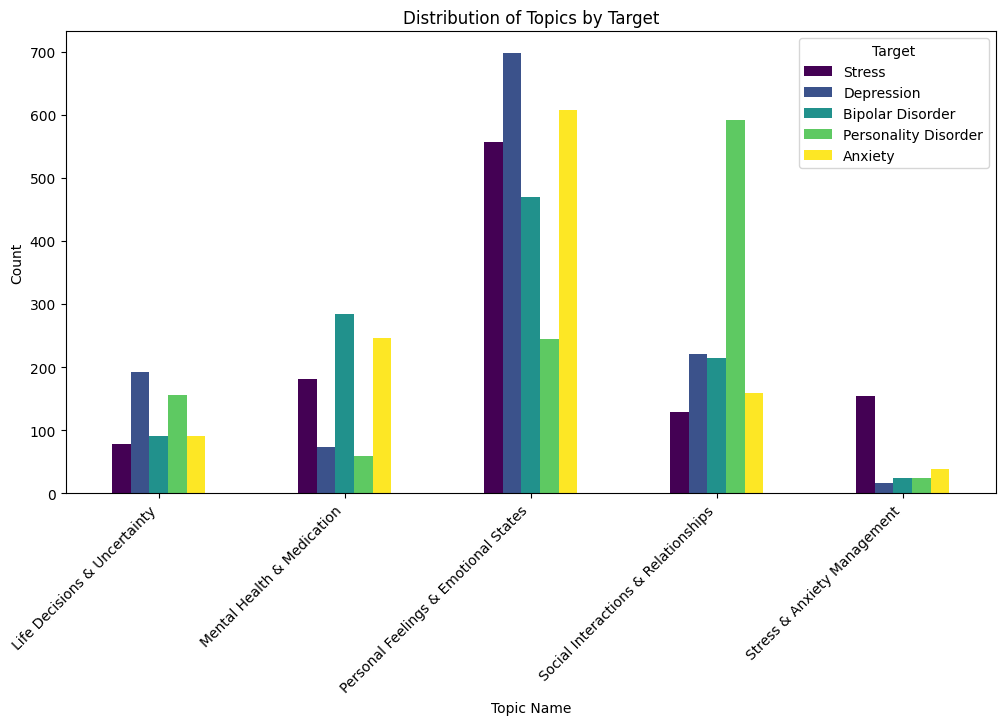

In [20]:
# Plot the bar chart with separate bars for each target
import matplotlib.pyplot as plt

# Define target labels
target_labels = {
    0: "Stress",
    1: "Depression",
    2: "Bipolar Disorder",
    3: "Personality Disorder",
    4: "Anxiety"
}

# Group by topic and target
topic_target_counts = df4.groupby(['topic_name', 'target']).size().unstack()

# Rename legend labels
topic_target_counts.rename(columns=target_labels, inplace=True)

plt.figure(figsize=(12, 6))
topic_target_counts.plot(kind='bar', colormap='viridis', figsize=(12,6))

# Customize labels and title
plt.xlabel("Topic Name")
plt.ylabel("Count")
plt.title("Distribution of Topics by Target")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Target")

# Show plot
plt.show()

# BERT Embeddings

In [8]:
# Load the pre-trained BERT tokenizer and model.
# We use BertModel (without a classification head) for feature extraction.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()  # Set the model to evaluation mode to ensure that dropout and other training-specific layers are deactivated

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [9]:
# Parameters for tokenization
max_length = 256  # Adjust as needed
batch_size = 8   # Adjust batch size based on your hardware

# Tokenize all texts
texts = df4["combined_text"].tolist()
labels = df4["target"].tolist()

# Tokenize with padding and truncation. Setting return_tensors="pt" to get PyTorch tensors.
encoded_inputs = tokenizer(texts,
                           padding=True,
                           truncation=True,
                           max_length=max_length,
                           return_tensors='pt')

In [10]:
# Create a PyTorch dataset and DataLoader for batching.
dataset = TensorDataset(encoded_inputs['input_ids'],
                        encoded_inputs['attention_mask'],
                        torch.tensor(labels))
dataloader = DataLoader(dataset, batch_size=batch_size)

# Initialize a list to hold embeddings and corresponding labels.
all_embeddings = []
all_labels = []

# Disable gradient calculation for inference.
with torch.no_grad():
    for batch in tqdm(dataloader, desc="Generating BERT Embeddings"):
        input_ids, attention_mask, batch_labels = batch

        # Get model outputs. outputs.last_hidden_state has shape (batch_size, sequence_length, hidden_size)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Extract the embedding corresponding to the [CLS] token (first token)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # shape: (batch_size, hidden_size)

        # Append to our list (move to CPU and convert to numpy array)
        all_embeddings.append(cls_embeddings.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

# Stack all embeddings into a single NumPy array.
X = np.vstack(all_embeddings)  # Shape: (num_samples, hidden_size)
y = np.array(all_labels)


Generating BERT Embeddings:   0%|          | 0/351 [00:00<?, ?it/s]

In [11]:
# make sure X has the right shape
X.shape

(5607, 768)

In [12]:
# make sure y has the right shape
y.shape

(5607,)

# Classifier

## JUST AN LOGISTIC REGRESSION EXAMPLE - MAGGIE

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use a logistic regression classifier (or choose any other classifier)
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.64349376114082
